In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Feature engineering some possible useful features

In [5]:
# Create an `hour` column instead of `step` column because it might be useful to see how fraud payment occur at an hourly level in a day.
df["hour"] = (df["step"] - 1) % 24

In [6]:
# Balance Change: Calculate the change in the origin and destination balances
df["orig_balance_change"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["dest_balance_change"] = df["oldbalanceDest"] - df["newbalanceDest"]

In [7]:
# Balance-to-Transaction Ratio: The ratio of the transaction amount to the origin account balance
df["amount_to_orig_balance_ratio"] = df["amount"] / (df["oldbalanceOrg"] + 1)

In [8]:
# Is Zero Balance After Transaction: Flag cases where the origin account's balance is zero immediately after the transaction
df["is_zero_balance_after"] = (df["newbalanceOrig"] == 0).astype(int)

In [9]:
# High-Value Transfer: Flag transactions that are above a certain threshold (e.g., 95th percentile) as potentially suspicious
high_value_threshold = df["amount"].quantile(0.95)
df["high_value_transfer"] = (df["amount"] > high_value_threshold).astype(int)

Accounts starting with 'C': Likely represent individual customers or clients involved in regular transactions like payments, transfers, or withdrawals.
Accounts starting with 'M': Represent merchant or business accounts that may act as recipients for payments.

In [10]:
# dest_account_type: the destination account starts with ‘M’, as merchants are less likely to engage in fraud
df["dest_account_type"] = df["nameDest"].str[0]

Balance masking refers to cases where the origin and destination account balances are manipulated or structured in such a way that they look similar, either before or after the transaction. This technique is sometimes used to avoid detection by fraud detection systems, as similar balances can make the transaction appear less suspicious.

In [11]:
# Orig/Dest Same Balance: Check if the origin and destination balances are the same before or after the transaction, which may indicate balance masking
df["same_balance_before"] = (df["oldbalanceOrg"] == df["oldbalanceDest"]).astype(int)
df["same_balance_after"] = (df["newbalanceOrig"] == df["newbalanceDest"]).astype(int)

In [12]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,orig_balance_change,dest_balance_change,amount_to_orig_balance_ratio,is_zero_balance_after,high_value_transfer,same_balance_before,same_balance_after
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,1.459148e+01,-2.123056e+04,-1.242947e+05,7.067448e+04,5.673081e-01,5.000000e-02,1.219851e-01,1.752985e-01
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,4.100153e+00,1.466433e+05,8.129391e+05,5.084243e+05,4.954489e-01,2.179450e-01,3.272687e-01,3.802223e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.915268e+06,-1.056878e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,-1.491054e+05,2.344011e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,6.453832e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,1.800000e+01,1.015044e+04,0.000000e+00,1.228776e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,2.300000e+01,1.000000e+07,1.306083e+07,9.244552e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### EDA

In [13]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Dataset is heavily unbalanced.

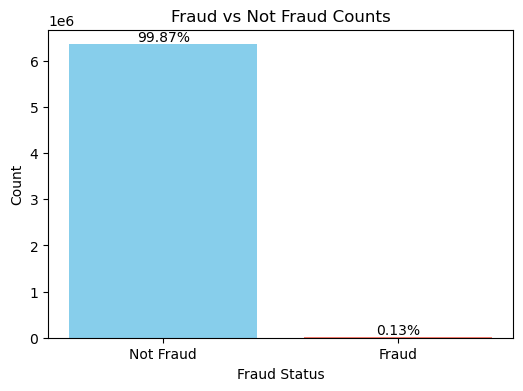

In [14]:
counts = df["isFraud"].value_counts()
labels = ["Not Fraud", "Fraud"]

# Calculate percentages
total = counts.sum()
percentages = [count / total * 100 for count in counts]

# Bar plot with percentages on top of each bar
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, color=["skyblue", "salmon"])

# Adding the percentage labels on top of each bar
for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 20,
        f"{percentage:.2f}%",
        ha="center",
        va="bottom",
    )

plt.xlabel("Fraud Status")
plt.ylabel("Count")
plt.title("Fraud vs Not Fraud Counts")
plt.show()

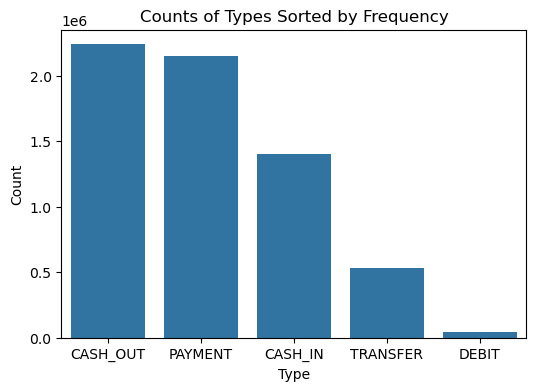

In [15]:
type_counts = df["type"].value_counts().index

# Creating the count plot with sorted bars
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="type", order=type_counts)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Counts of Types Sorted by Frequency")
plt.show()

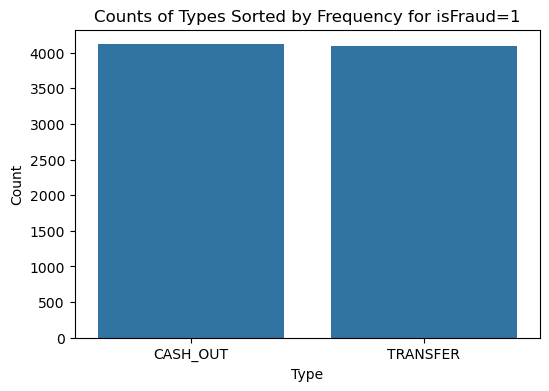

In [16]:
type_counts = df[df["isFraud"] == 1]["type"].value_counts().index

# Creating the count plot with sorted bars
plt.figure(figsize=(6, 4))
sns.countplot(data=df[df["isFraud"] == 1], x="type", order=type_counts)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Counts of Types Sorted by Frequency for isFraud=1")
plt.show()

Fraud payments only occured for CASH_OUT and TRANSFER types.

In [17]:
transfer_fraud_percentage = (len(df[(df["isFraud"] == 1) & (df["type"] == "TRANSFER")]) / len(df[df["type"] == "TRANSFER"])* 100)
cashout_fraud_percentage = (len(df[(df["isFraud"] == 1) & (df["type"] == "CASH_OUT")]) / len(df[df["type"] == "CASH_OUT"]) * 100)
print(f'Percentage of fraud Transfer transactions: {"%0.2f%%" % transfer_fraud_percentage}')
print(f'Percentage of fraud Cash Out transactions: {"%0.2f%%" % cashout_fraud_percentage}')

Percentage of fraud Transfer transactions: 0.77%
Percentage of fraud Cash Out transactions: 0.18%


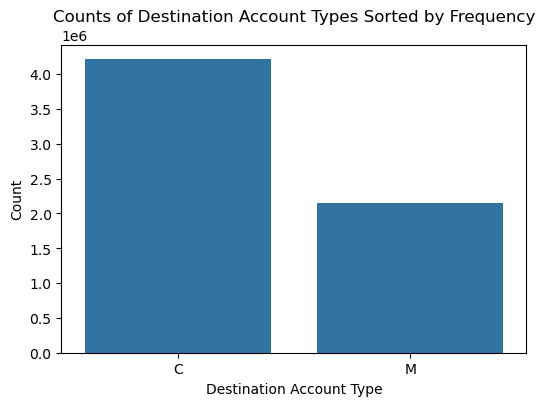

In [18]:
type_counts = df["dest_account_type"].value_counts().index

# Creating the count plot with sorted bars
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="dest_account_type", order=type_counts)
plt.xlabel("Destination Account Type")
plt.ylabel("Count")
plt.title("Counts of Destination Account Types Sorted by Frequency")
plt.show()

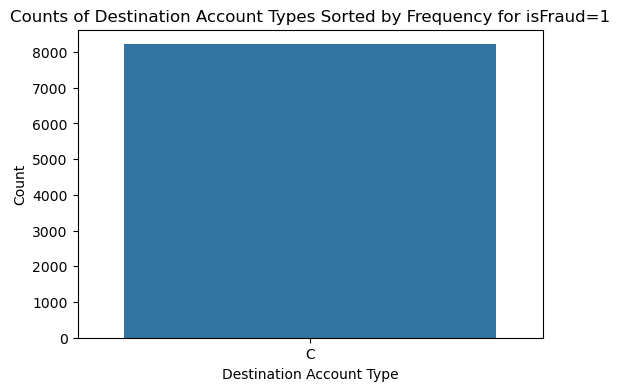

In [19]:
type_counts = df[df["isFraud"] == 1]["dest_account_type"].value_counts().index

# Creating the count plot with sorted bars
plt.figure(figsize=(6, 4))
sns.countplot(data=df[df["isFraud"] == 1], x="dest_account_type", order=type_counts)
plt.xlabel("Destination Account Type")
plt.ylabel("Count")
plt.title("Counts of Destination Account Types Sorted by Frequency for isFraud=1")
plt.show()

All fraud transactions were of type 'C'.

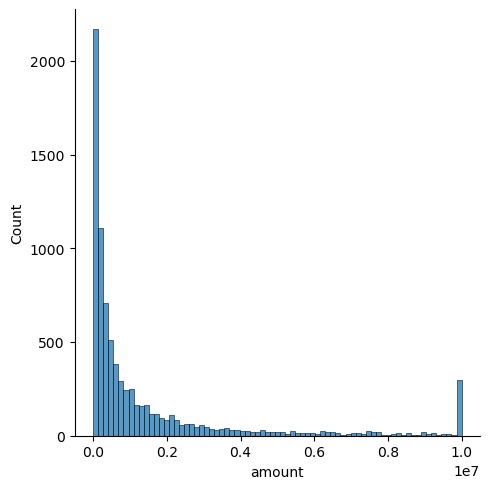

In [20]:
sns.displot(data=df[df["isFraud"] == 1], x="amount");

From the distribution above we can infer that many of the fraud payments occurred below 2 million, and around 1 billion.

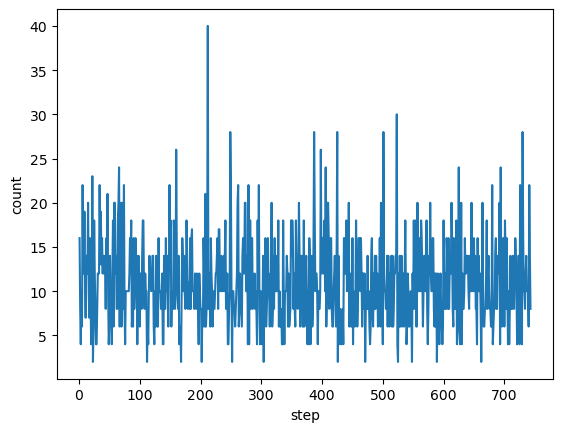

In [21]:
plt.plot(df[df["isFraud"] == 1]["step"].value_counts().sort_index())
# we could also have used plt.plot(df.groupby('step')['isFraud'].sum())
plt.xlabel("step")
plt.ylabel("count")
plt.show();

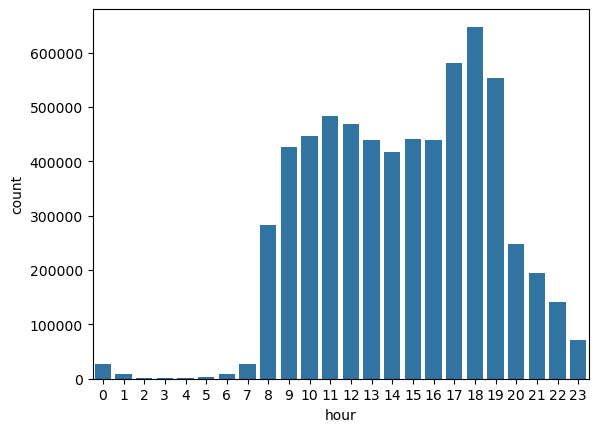

In [22]:
sns.countplot(df, x="hour");

Not many payments occur in hours 0 to 7 which is expected.

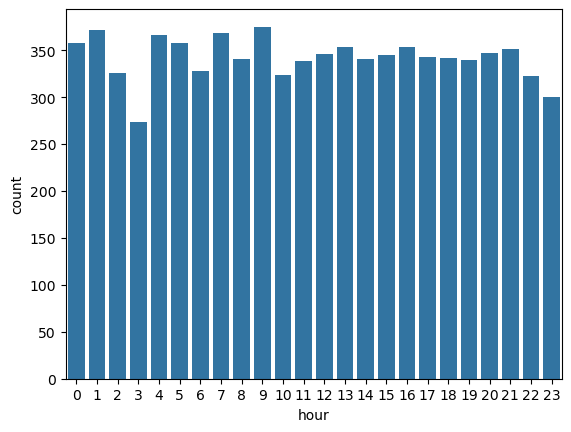

In [23]:
sns.countplot(df[df["isFraud"] == 1], x="hour");

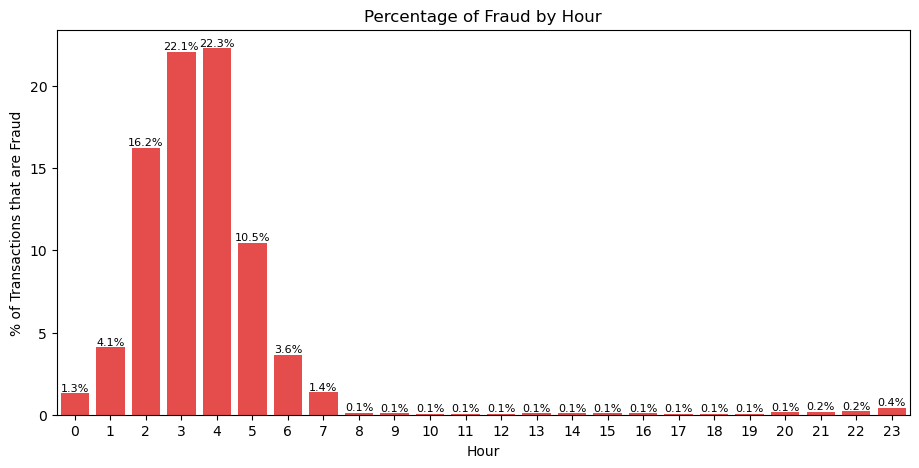

In [24]:
fraud_percentage_by_hour = (
    df[df["isFraud"] == 1]["hour"].value_counts() / df["hour"].value_counts()
) * 100

plt.figure(figsize=(11, 5))
sns.barplot(
    x=fraud_percentage_by_hour.index,
    y=fraud_percentage_by_hour.values,
    color="red",
    alpha=0.8,
)

plt.xlabel("Hour")
plt.ylabel("% of Transactions that are Fraud")
plt.title("Percentage of Fraud by Hour")

for index, value in enumerate(fraud_percentage_by_hour):
    plt.text(index, value, f"{value:.1f}%", ha="center", va="bottom", fontsize=8)

In [25]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'hour', 'orig_balance_change', 'dest_balance_change',
       'amount_to_orig_balance_ratio', 'is_zero_balance_after',
       'high_value_transfer', 'dest_account_type', 'same_balance_before',
       'same_balance_after'],
      dtype='object')

In [26]:
df_corr = df.drop(columns=
    [
        "step",
        'type',
        "nameOrig",
        "nameDest",
        "isFraud",
        "isFlaggedFraud",
        "dest_account_type",
        "is_zero_balance_after",
        "same_balance_before",
        "same_balance_after",
        'high_value_transfer'
    ]
).copy()

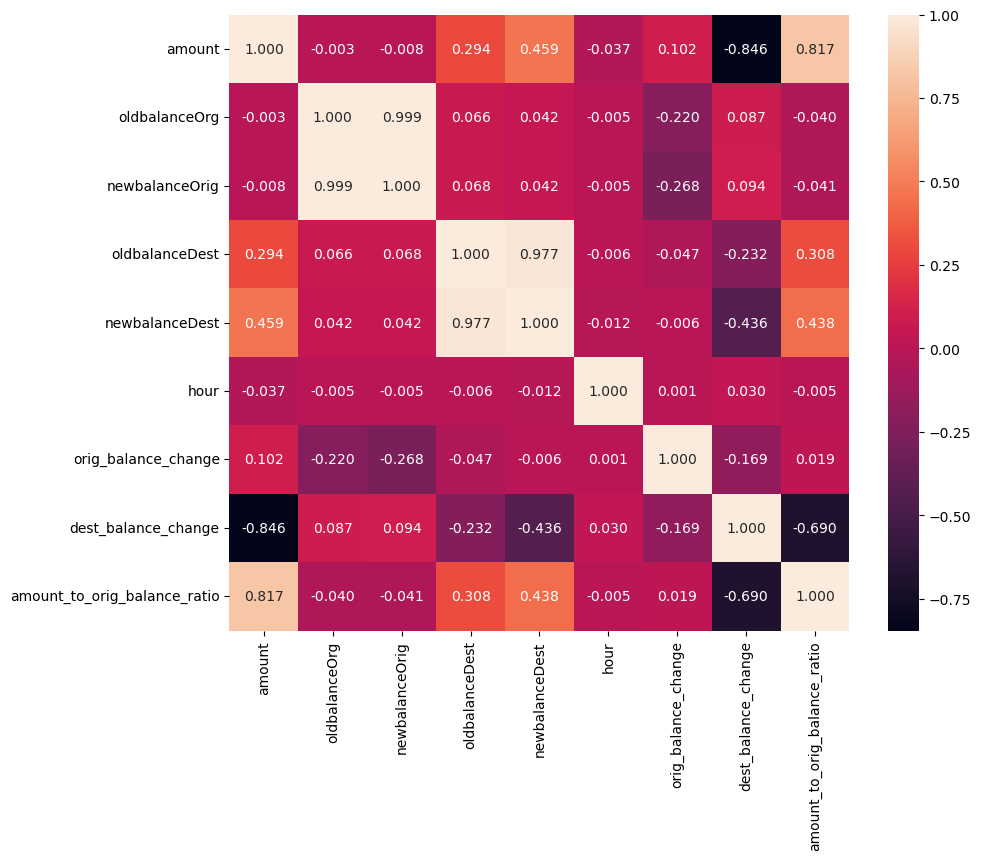

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(method="pearson"), annot=True, fmt=".3f")
plt.show()

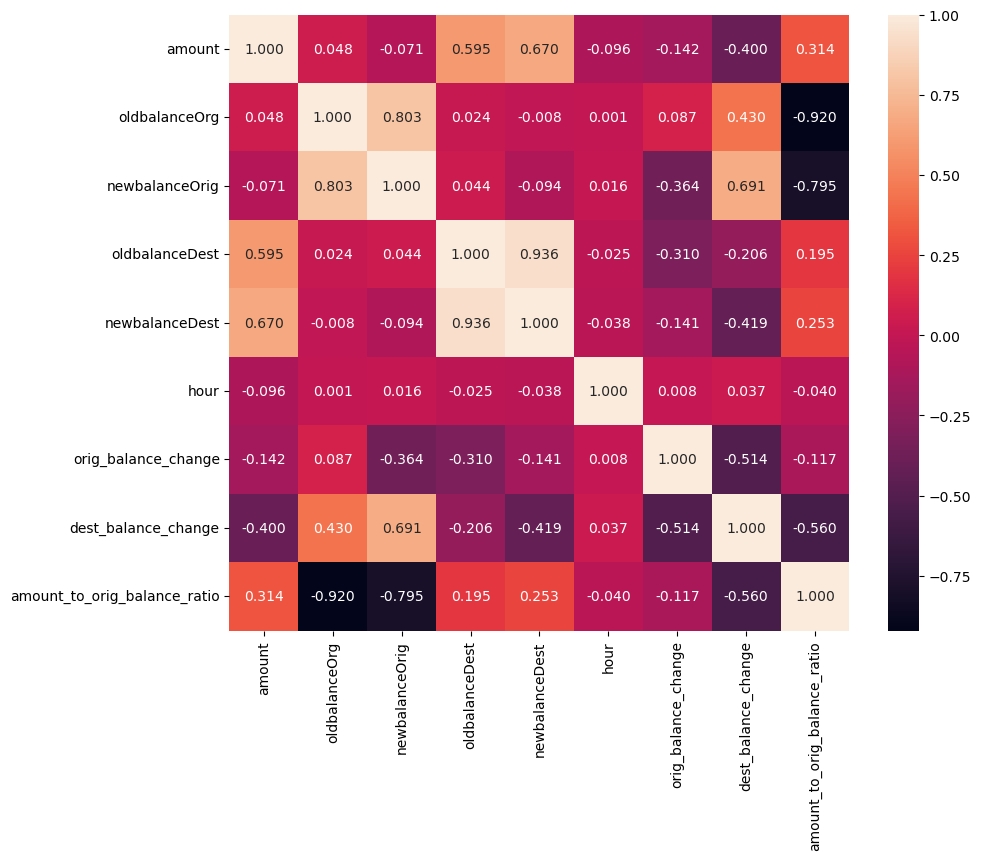

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(method="spearman"), annot=True, fmt=".3f")
plt.show()

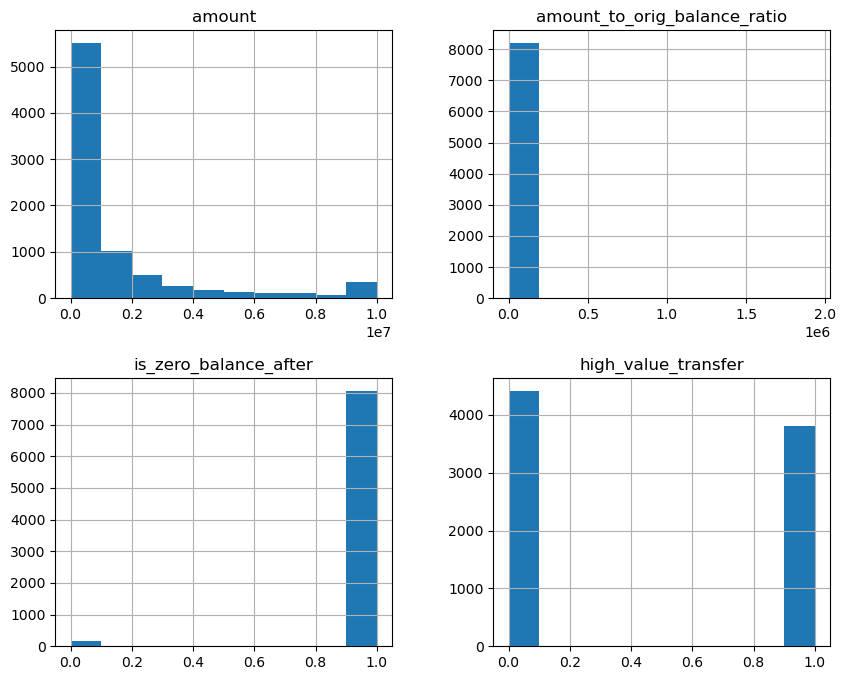

In [29]:
df[df["isFraud"] == 1][['amount', 'amount_to_orig_balance_ratio', 'is_zero_balance_after', 'high_value_transfer']].hist(figsize=(10,8));

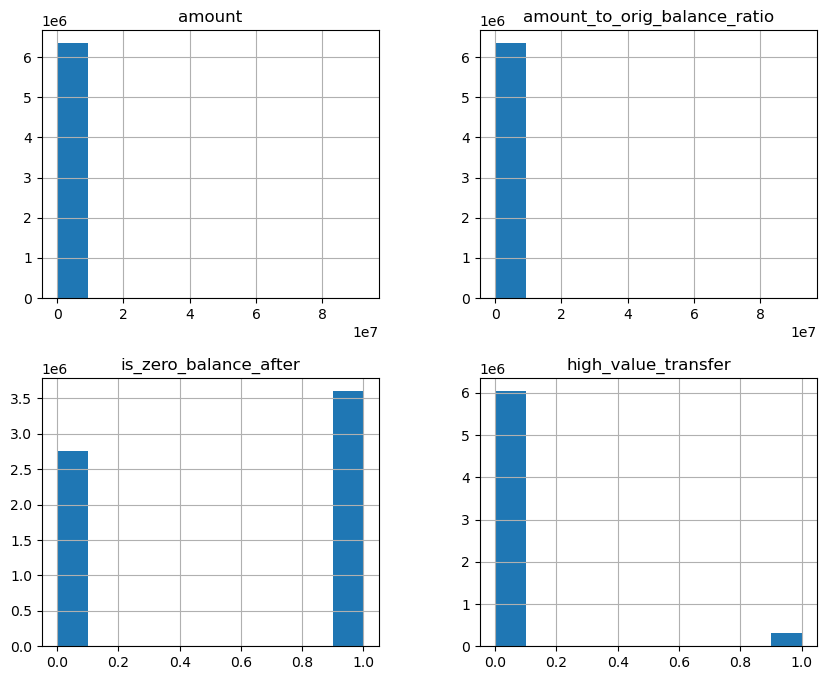

In [30]:
df[df["isFraud"] == 0][['amount', 'amount_to_orig_balance_ratio', 'is_zero_balance_after', 'high_value_transfer']].hist(figsize=(10,8));

'is_zero_balance_after' and 'high_value_transfer' seems to be good features.

In [31]:
df.to_parquet("df.parquet", index=False)